In [102]:
from rdkit import Chem
from rdkit.ML.Cluster import Murtagh
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem, QED
from rdkit.Chem import rdBase,rdMolDescriptors, DataStructs
import pandas as pd
import rdkit
from rdkit.Chem import rdFMCS
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
from sklearn.cluster import MiniBatchKMeans 
from sklearn.cluster import KMeans 
from sklearn import metrics

In [74]:
def ExtraGetClusterReport(mols):
    try: 
        mcs = rdFMCS.FindMCS(mols, threshold=0.8,
                             ringMatchesRingOnly=True,completeRingsOnly=False,
                             atomCompare=rdkit.Chem.rdFMCS.AtomCompare.CompareElements)
        p = Chem.MolFromSmarts(mcs.smartsString)
        AllChem.Compute2DCoords(p)
        core = Chem.MolFromSmarts(mcs.smartsString)
        AllChem.Compute2DCoords(core)
        halist = [mol.GetSubstructMatch(core) for mol in mols]
    except ValueError: 
        mcs=None
        halist = None
    if mcs: 
        for m in mols: 
            try: 
                AllChem.GenerateDepictionMatching2DStructure(m,p)
                AllChem.Compute2DCoords(m)
            except ValueError: 
                AllChem.Compute2DCoords(m)
    img = Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300),highlightAtomLists=halist,
                               useSVG=False,legends=[x.GetProp("_Name") for x in mols])
    return img

In [113]:
def Get3Dfrom2D(m):
    m2=Chem.AddHs(m)
    AllChem.EmbedMolecule(m2)
    AllChem.UFFOptimizeMolecule(m2)
    return m2

In [87]:
tot_sdf_file = './Sel_gt_0.5_and_pki_gt_6p5.sdf'
all_mol_list = {x.GetProp('_Name'):x for x in Chem.SDMolSupplier(tot_sdf_file)}
df_all = pd.DataFrame.from_dict(all_mol_list,orient='index')
df_all.columns = ['molecule']
fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(x,2,nBits=2048) for x in df_all.molecule]
np_fps = []
for fp in fps:
  arr = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  np_fps.append(arr)
#df_all

## Finding Optimal Number of Clusters

/Users/leela.dodda/anaconda3/envs/deepchem/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


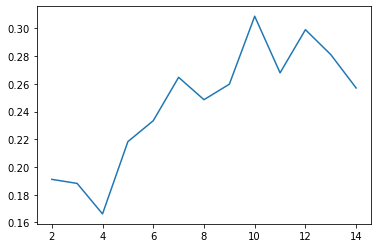

In [88]:
X = []
Y = []
Z = []
for iv in range(2,15):
    #kmeans_model = MiniBatchKMeans(n_clusters=iv,batch_size=300).fit(X=np_fps)  
    kmeans_model = KMeans(n_clusters=iv).fit(X=np_fps) 
    x, y = (kmeans_model.n_clusters,metrics.silhouette_score(np_fps, kmeans_model.labels_,metric='dice'))
    X.append(x)
    Y.append(y)
    Z.append(kmeans_model.inertia_)
plt.plot(X,Y)


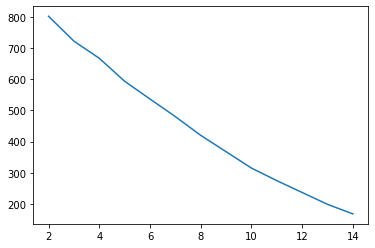

In [89]:
plt.plot(X,Z)

In [90]:
kmeans_model = KMeans(n_clusters=10).fit(X=np_fps) 
kmeans_model.inertia_

311.95000000000005

In [91]:
kmeans_model.labels_.shape

(25,)

## Selecting compounds with high QED score i.e., drug-like ness

In [111]:
df_all['cluster'] = kmeans_model.labels_
df_all['QED'] = [QED.qed(m) for m in df_all.molecule]
df_all[df_all.QED > 0.3]

,molecule,cluster,QED
DB08569,<rdkit.Chem.rdchem.Mol object at 0x1a2a6d5850>,3,0.460743
DB07107,<rdkit.Chem.rdchem.Mol object at 0x1a2a6d58a0>,3,0.513901
DB04853,<rdkit.Chem.rdchem.Mol object at 0x1a2a6d5990>,6,0.348323
DB02075,<rdkit.Chem.rdchem.Mol object at 0x1a2a6d5a30>,0,0.322024
DB04060,<rdkit.Chem.rdchem.Mol object at 0x1a2a6d5a80>,0,0.588039
DB12964,<rdkit.Chem.rdchem.Mol object at 0x1a2a6d5b70>,7,0.804949
DB11878,<rdkit.Chem.rdchem.Mol object at 0x1a2a6d5c10>,7,0.425460
DB08503,<rdkit.Chem.rdchem.Mol object at 0x1a2a6d5ee0>,2,0.482674
DB08500,<rdkit.Chem.rdchem.Mol object at 0x1a2a6d5f80>,2,0.518913
DB04865,<rdkit.Chem.rdchem.Mol object at 0x1a2a6d9030>,9,0.447625


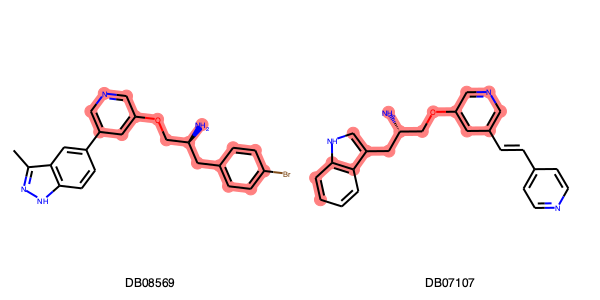

In [110]:
### This Gives Hits in Cluster 
cluster_no = 3
mlist = df_all[(df_all.cluster==cluster_no)&(df_all.QED > 0.3)].molecule
#mlist = df_all[(df_all.cluster==cluster_no)&(df_all.label==1)].molecule
#Draw.MolsToGridImage(mlist,legends=[x.GetProp("Molecule Name") for x in mlist])
ExtraGetClusterReport(mlist)

In [12]:
print(singletons)

15


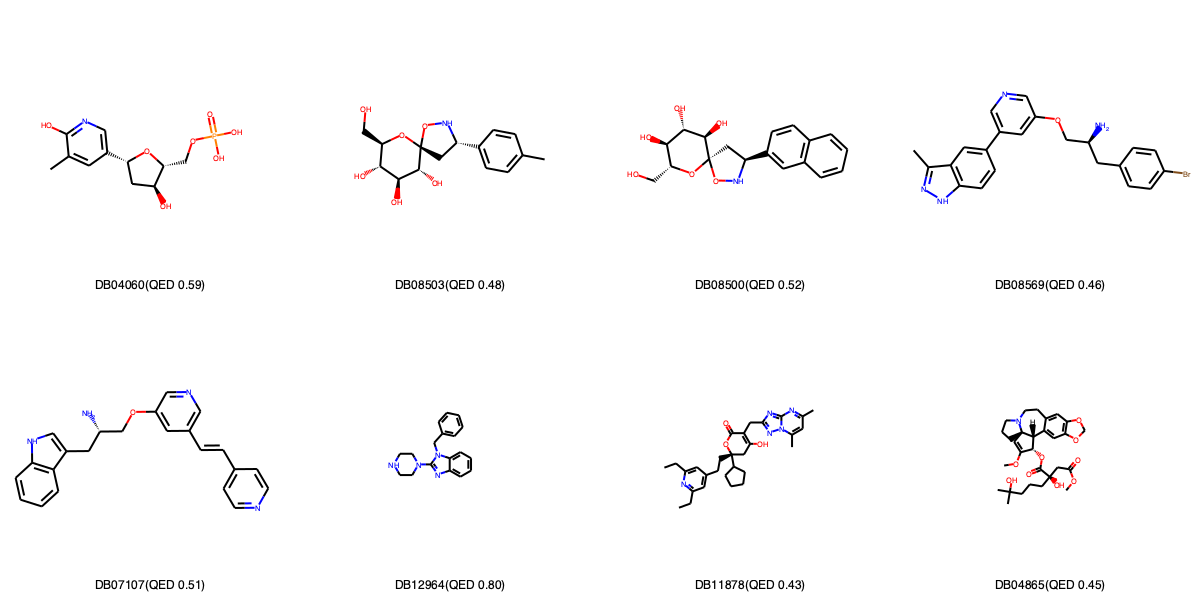

In [131]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
ndf = df_all[(df_all.QED > 0.4)]
ndf = ndf.sort_values('cluster')
Draw.MolsToGridImage(ndf.molecule,molsPerRow=4,legends=[r.molecule.GetProp("_Name")+'(QED %.2f)'%r.QED for i,r in ndf.iterrows()],subImgSize=(300,300))

In [132]:
from rdkit.Chem import PandasTools

In [133]:
dbase = PandasTools.LoadSDF('Sel_gt_0.5_and_pki_gt_6p5.sdf')

In [136]:
sel_ids = [mol.GetProp("_Name") for mol in ndf.molecule]

In [156]:
dbase[dbase.DRUGBANK_ID.isin(sel_ids)][['DRUGBANK_ID','DRUG_GROUPS','JCHEM_RULE_OF_FIVE','JCHEM_PHYSIOLOGICAL_CHARGE','GENERIC_NAME','JCHEM_BIOAVAILABILITY','ALOGPS_LOGP']].to_csv('final_selected.csv',index=False)

In [160]:
list(dbase[dbase.DRUGBANK_ID.isin(sel_ids)]['SMILES'])

['[H][C@@](N)(COC1=CN=CC(=C1)C1=CC2=C(NN=C2C)C=C1)CC1=CC=C(Br)C=C1',
 '[H][C@@](N)(COC1=CN=CC(\\C=C\\C2=CC=NC=C2)=C1)CC1=CNC2=C1C=CC=C2',
 '[H][C@]1(O)C[C@@]([H])(O[C@]1([H])COP(O)(O)=O)C1=CN=C(O)C(C)=C1',
 'C(N1C2=CC=CC=C2N=C1N1CCNCC1)C1=CC=CC=C1',
 'CCC1=CC(CC[C@@]2(CC(O)=C(CC3=NN4C(=N3)N=C(C)C=C4C)C(=O)O2)C2CCCC2)=CC(CC)=N1',
 '[H][C@]1(C[C@]2(ON1)O[C@]([H])(CO)[C@@]([H])(O)[C@]([H])(O)[C@@]2([H])O)C1=CC=C(C)C=C1',
 '[H][C@]1(C[C@]2(ON1)O[C@]([H])(CO)[C@@]([H])(O)[C@]([H])(O)[C@@]2([H])O)C1=CC2=CC=CC=C2C=C1',
 '[H][C@@]1(OC(=O)[C@@](O)(CCCC(C)(C)O)CC(=O)OC)C(OC)=C[C@]23CCCN2CCC2=CC4=C(OCO4)C=C2[C@]13[H]']

In [161]:
list(dbase[dbase.DRUGBANK_ID.isin(sel_ids)]['JCHEM_PHYSIOLOGICAL_CHARGE'])

['1', '1', '-2', '1', '-1', '0', '0', '1']

In [162]:
list(dbase[dbase.DRUGBANK_ID.isin(sel_ids)]['DRUGBANK_ID'])

['DB08569',
 'DB07107',
 'DB04060',
 'DB12964',
 'DB11878',
 'DB08503',
 'DB08500',
 'DB04865']

In [170]:
mol_list = {
    'DB08569': '[H][C@@](COC1=CN=CC(C2=CC3=C(C=C2)NN=C3C)=C1)(CC4=CC=C(C=C4)Br)[NH3+]',
    'DB07107': '[H][C@@](COC1=CN=CC(/C=C/C2=CC=NC=C2)=C1)(CC3=CNC4=C3C=CC=C4)[NH3+]',
    'DB04060': '[H][C@@]1(C[C@@](O[C@@]1(COP([O-])([O-])=O)[H])(C2=CN=C(C(C)=C2)O)[H])O',
    'DB12964': 'N1(C2=CC=CC=C2N=C1N3CC[NH2+]CC3)CC4=CC=CC=C4',
    'DB11878': 'CCC1=CC(CC[C@]2(C3CCCC3)CC([O-])=C(C(O2)=O)CC4=NN5C(N=C(C=C5C)C)=N4)=CC(CC)=N1',
    'DB08503': '[H][C@@]1(C2=CC=C(C=C2)C)C[C@@]3(O[C@](CO)([C@@](O)([C@](O)([C@]3(O)[H])[H])[H])[H])ON1',
    'DB08500': '[H][C@@]1(C2=CC3=CC=CC=C3C=C2)C[C@@]4(O[C@](CO)([C@@](O)([C@](O)([C@]4(O)[H])[H])[H])[H])ON1',
    'DB04865': '[H][C@@]1(OC(=O)[C@@](O)(CCCC(C)(C)O)CC(=O)OC)C(OC)=C[C@]23CCC[NH+]2CCC2=CC4=C(OCO4)C=C2[C@]13[H]',
    'DB04865Prodrug' : '[H][C@]1(C(OC)=C[C@]23CCC[NH+]2CCC4=CC5=C(C=C4[C@]13[H])OCO5)O'
    }

In [171]:
mol_dict = {}
for k in list(mol_list.keys()):
    mol_dict[k] = Get3Dfrom2D(Chem.MolFromSmiles(mol_list[k]))
    mol_dict[k].SetProp("_Name",k) 

In [172]:
w = Chem.SDWriter('final_selected_standardize.sdf')
for k in list(mol_dict.keys()): w.write(mol_dict[k])
w.close()